In [572]:
import pandas as pd
df = pd.read_csv('diabetes.csv')

In [573]:
# Se importan librerías para graficar.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [574]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [575]:
print(df.shape)

(768, 9)


In [576]:
df_values = df.values
x = df_values[:,:-1]
y = df_values[:, -1].reshape(x.shape[0], 1)

In [577]:
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Activation, Input
import keras.regularizers

In [578]:
# Instantiate the model.
model = Sequential()
model.add(Dense(1, input_shape=(x.shape[1],)))

# Adding the final activation, i.e., sigmoid.
model.add(Activation('sigmoid'))

# Printing the model summary.
print(model.summary())

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_31 (Dense)             (None, 1)                 9         
_________________________________________________________________
activation_26 (Activation)   (None, 1)                 0         
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________
None


In [579]:
# Mean, columnar axis.
x_mean = np.mean(x, axis=0, keepdims=True)

# Std. Deviation, columnar axis.
x_std = np.std(x, axis=0, keepdims=True)

# Normalizing.
x = (x - x_mean)/x_std

print(x[:5, :])

[[ 0.63994726  0.84832379  0.14964075  0.90726993 -0.69289057  0.20401277
   0.46849198  1.4259954 ]
 [-0.84488505 -1.12339636 -0.16054575  0.53090156 -0.69289057 -0.68442195
  -0.36506078 -0.19067191]
 [ 1.23388019  1.94372388 -0.26394125 -1.28821221 -0.69289057 -1.10325546
   0.60439732 -0.10558415]
 [-0.84488505 -0.99820778 -0.16054575  0.15453319  0.12330164 -0.49404308
  -0.92076261 -1.04154944]
 [-1.14185152  0.5040552  -1.50468724  0.90726993  0.76583594  1.4097456
   5.4849091  -0.0204964 ]]


In [580]:
from sklearn.model_selection import train_test_split

# Split the model into a 0.9-0.1 train-test split.
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=5)

print("Shape of x_train: ", x_train.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of x_test: ", x_test.shape)
print("Shape of y_test: ", y_test.shape)

Shape of x_train:  (691, 8)
Shape of y_train:  (691, 1)
Shape of x_test:  (77, 8)
Shape of y_test:  (77, 1)


In [581]:
import tensorflow as tf
from keras import backend as K

def specificity(y_true, y_pred):
    tn = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    fp = K.sum(K.round(K.clip((1 - y_true) * y_pred, 0, 1)))
    return tn / (tn + fp + K.epsilon())


def negative_predictive_value(y_true, y_pred):
    tn = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    fn = K.sum(K.round(K.clip(y_true * (1 - y_pred), 0, 1)))
    return tn / (tn + fn + K.epsilon())

def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    sens_keras = true_positives / (possible_positives + K.epsilon())
    return sens_keras

def positive_predictive_value(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    ppv_keras = true_positives / (predicted_positives + K.epsilon())
    return ppv_keras

In [582]:
from keras import metrics
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[metrics.AUC(), specificity,sensitivity,
        negative_predictive_value, positive_predictive_value])

In [583]:
# Fit the data to the model and get the per-batch metric history.
history = model.fit(x_train, y_train, validation_split=0.2, 
                    batch_size=10, epochs=100, 
                   verbose='auto')

 0.4728 - auc_12: 0.8354 - specificity: 0.8887 - sensitivity: 0.5594 - negative_predictive_value: 0.7976 - positive_predictive_value: 0.6638 - val_loss: 0.4668 - val_auc_12: 0.8508 - val_specificity: 0.9092 - val_sensitivity: 0.5190 - val_negative_predictive_value: 0.7740 - val_positive_predictive_value: 0.7083
Epoch 50/100
56/56 [==============================] - 0s 3ms/step - loss: 0.4522 - auc_12: 0.8579 - specificity: 0.9186 - sensitivity: 0.5690 - negative_predictive_value: 0.8043 - positive_predictive_value: 0.7115 - val_loss: 0.4663 - val_auc_12: 0.8515 - val_specificity: 0.9092 - val_sensitivity: 0.5548 - val_negative_predictive_value: 0.7859 - val_positive_predictive_value: 0.7190
Epoch 51/100
56/56 [==============================] - 0s 3ms/step - loss: 0.4642 - auc_12: 0.8452 - specificity: 0.8862 - sensitivity: 0.5458 - negative_predictive_value: 0.8017 - positive_predictive_value: 0.6713 - val_loss: 0.4660 - val_auc_12: 0.8509 - val_specificity: 0.9092 - val_sensitivity: 0.

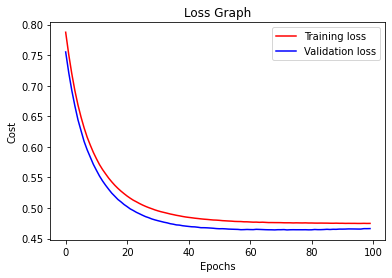

In [584]:
# Plot the training loss.
plt.plot(history.history['loss'], 'r-')

# Plot the validation loss.
plt.plot(history.history['val_loss'], 'b-')

# X-axis label.
plt.xlabel('Epochs')

# Y-axis label.
plt.ylabel('Cost')

# Graph legend.
plt.legend(["Training loss", "Validation loss"])

# Graph title.
plt.title('Loss Graph')

plt.show()

In [585]:
predictions = model.predict(x_test)

In [586]:
from sklearn.metrics import roc_curve
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, predictions)
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

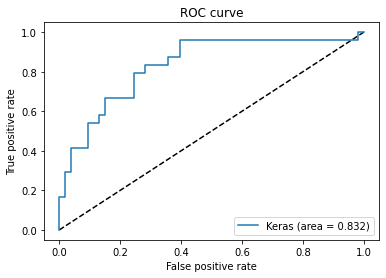

In [587]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [588]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, rounded_preds)

array([[45,  8],
       [ 8, 16]], dtype=int64)

In [589]:
from sklearn.metrics import precision_score
rounded_preds = np.rint(predictions)

print('Specificity: ' + str(specificity(y_test.astype(float), predictions.astype(float))))
print('Sensitivity: ' + str(sensitivity(y_test.astype(float), predictions.astype(float))))
print('Positive Predictive Value: ' + str(positive_predictive_value(y_test.astype(float), predictions.astype(float))))
print('Negative Predictive Value: ' + str(negative_predictive_value(y_test.astype(float), predictions.astype(float))))

Specificity: tf.Tensor(0.8490566021715913, shape=(), dtype=float64)
Sensitivity: tf.Tensor(0.5833333309027777, shape=(), dtype=float64)
Positive Predictive Value: tf.Tensor(0.6363636334710744, shape=(), dtype=float64)
Negative Predictive Value: tf.Tensor(0.8181818166942149, shape=(), dtype=float64)
